In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import copy
from scipy.signal import find_peaks, resample
from icecream import ic
from collections import OrderedDict

from neurolib.models.aln import ALNModel
#from neurolib.models.aln import ALNModel_SaveSteps
import neurolib.utils.stimulus as stim
import neurolib.utils.functions as func  
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
import os
import sys
from pynverse import inversefunc

from intersect import intersection
from scipy.stats import mode


sys.path.insert(0, '..')
from prc_funcs import *
from functions import *
    

import matplotlib.colors as mcolors

colors = mcolors.TABLEAU_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
colrs = [name for hsv, name in by_hsv]

#hide
import logging
logging.getLogger().setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")

BASE_PATH = "../../../../" # need to go back from default hdf path "./data/hdf"
HDF_PATH = BASE_PATH + "Data/"


# Pics of 2-Node model In- and Anti-phase and unequal phases traces
# And Pic of bistability with stimulations

In [2]:
Cmat = np.ones((2,2))
np.fill_diagonal(Cmat, 0)
Dmat = Cmat.copy()
Dmat *= 50 

aln = ALNModel(Cmat = Cmat, Dmat = Dmat)
# Put ALN in "A3" Point right inside the LC_EI
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5

# no adaptation 
aln.params['a'] = 0.
aln.params['b'] = 0. 

# coupling strength
aln.params['Ke_gl'] = 20.
aln.params['dt'] = 0.1
aln.params['duration'] = 20 * 1000 

def delayToVelocity(delay, distance=50):
    '''delay in my, distance in mm'''
    return distance / delay

delay = 46 # ca. freerunning period
aln.params['signalV'] = delayToVelocity(delay)

inphase_antiphase_stimulus = construct_inphase_antiphase_stimulus(    
    duration=aln.params.duration,
    dt=0.1,
    stim_amp=0.3,
    stim_freq_in=20,
    stim_freq_anti=26,
    stim_bias=0,
    #n_periods_in=20,
    n_periods_anti=10,
    nostim_before=1000,
    nostim_after=0,
    decay=True
)
aln.params['ext_exc_current'] = inphase_antiphase_stimulus

aln.run()

INFO:root:aln: Model initialized.


Text(0.5, 1.0, 'In- and antiphasic stimulated 2-node ALN')

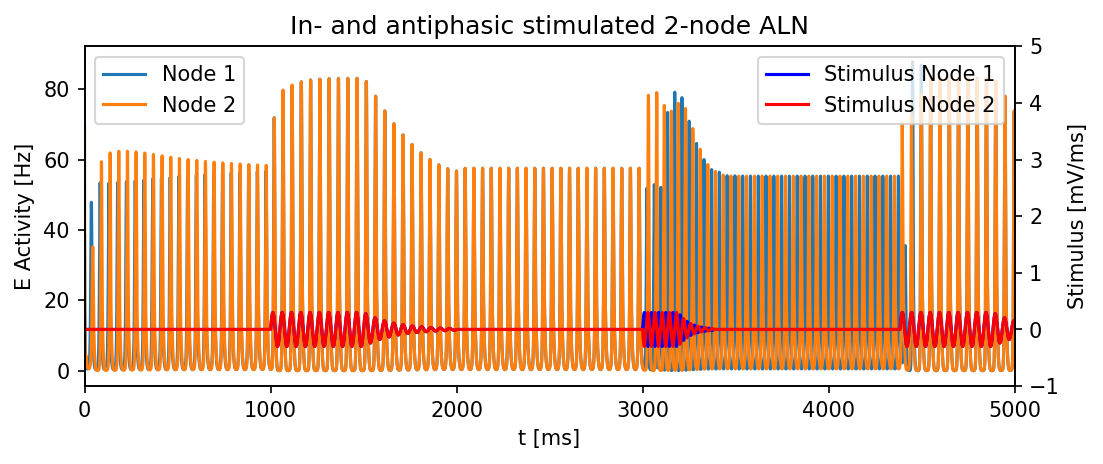

In [3]:
fig, ax = plt.subplots(figsize=(8,3), dpi=150)
ax2 = ax.twinx()
ax.plot(aln.t, aln.rates_exc[0, :], color = "tab:blue", label = "Node 1")
ax.plot(aln.t, aln.rates_exc[1, :], color = "tab:orange", label = "Node 2")
ax2.plot(aln.t, aln.params.ext_exc_current[0], color = "blue", label = "Stimulus Node 1")
ax2.plot(aln.t, aln.params.ext_exc_current[1], color = "red", label = "Stimulus Node 2")
ax.set_xlim(0, 5000)
ax.set_xlabel("t [ms]")
ax.set_ylabel("E Activity [Hz]")
ax2.set_ylabel("Stimulus [mV/ms]")
ax2.set_ylim(-1,5)
ax.legend(loc=2)
ax2.legend()
ax.set_title("In- and antiphasic stimulated 2-node ALN")

## now in my style

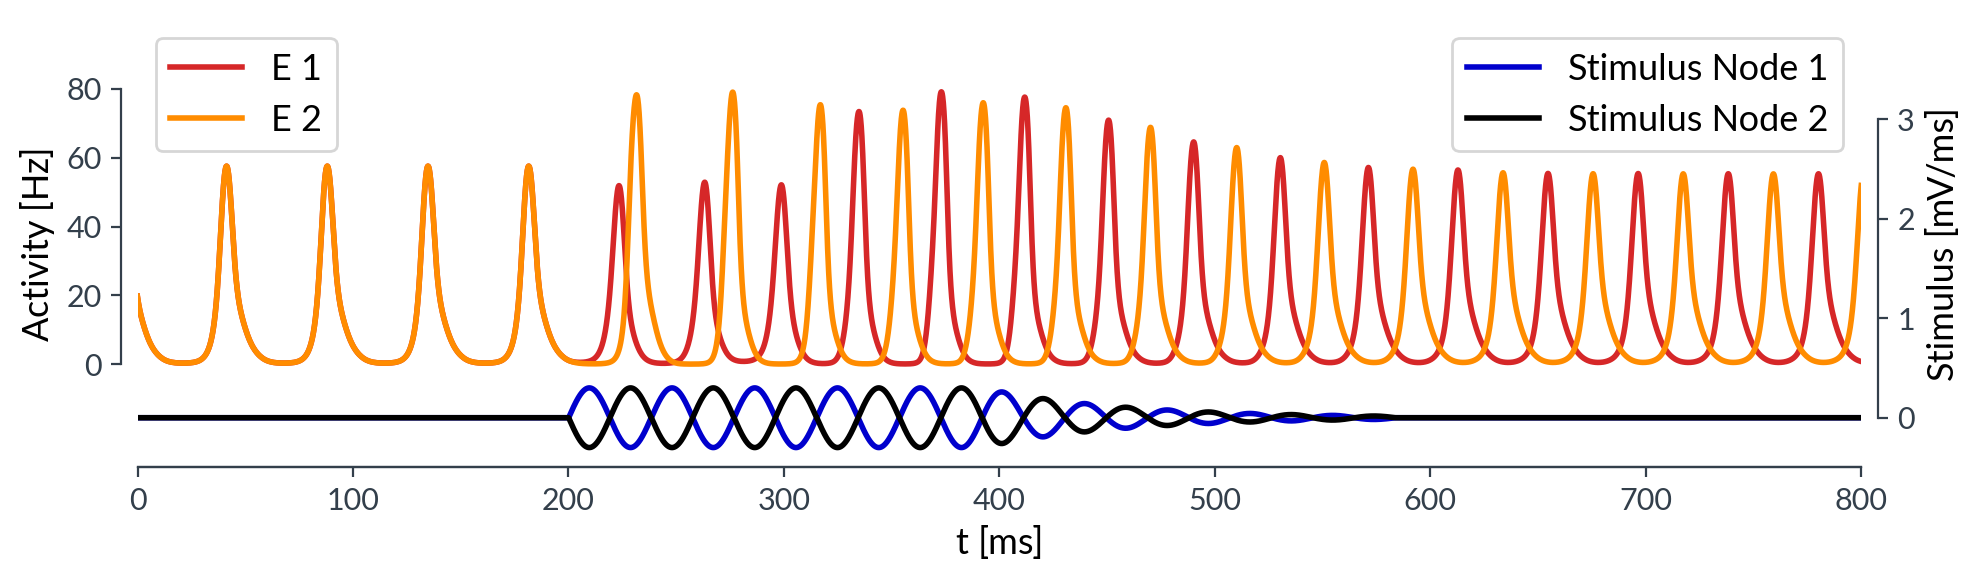

In [4]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

fig, ax = plt.subplots(figsize=(10, 3), dpi=200)

ax2 = ax.twinx()
ax.plot(aln.t, aln.rates_exc[0, :], color = "tab:red", label = "E 1", lw=2)
ax.plot(aln.t, aln.rates_exc[1, :], color = "darkorange", label = "E 2", lw=2)

ax2.plot(aln.t, aln.params.ext_exc_current[0], color = "mediumblue", label = "Stimulus Node 1", lw=2)
ax2.plot(aln.t, aln.params.ext_exc_current[1], color = "black", label = "Stimulus Node 2", lw=2)

ax.set_xlim(2800, 3600)
ax.set_xlabel("t [ms]")
ax.set_ylabel("Activity [Hz]")
ax2.set_ylabel("Stimulus [mV/ms]")

ax.set_ylim(-30, 100)
ax.set_yticks([0, 20, 40, 60, 80])
ax.set_yticklabels(labels=['0', '20', '40', '60', '80'] )
ax.legend(loc=2)
ax2.legend()

ax.spines['top'].set_visible(False), ax2.spines['top'].set_visible(False)

plt.draw()
lab = [float(item.get_text().replace("−", "-")) for item in ax.get_yticklabels(which='both')]
ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
ax.spines["left"].set_position(("outward", 6))
ax2.spines["left"].set_visible(False)

ax2.set_ylim(-0.5,4)
ax2.set_yticks([0, 1, 2, 3])
ax2.set_yticklabels(labels=['0', '1', '2', '3'] )
lab = [float(item.get_text().replace("−", "-")) for item in ax2.get_yticklabels(which='both')]
ax2.spines["right"].set_bounds(low=min(lab), high=max(lab))
ax2.spines["right"].set_position(("outward", 6))
ax.spines["right"].set_visible(False)
ax.set_xticks([i + 2800 for i in range(0, 900, 100)])
ax.set_xticklabels(labels=[str(i) for i in range(0, 900, 100)])

fig.tight_layout()
#fig.savefig("Pics/Stimulus_Bistability2.pdf")

## Pic of sync timeseries

INFO:root:aln: Model initialized.


(4800.0, 5000.0)

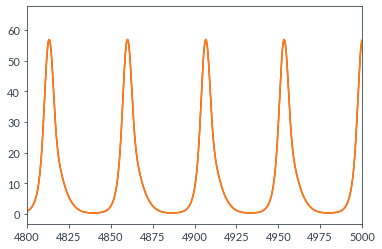

In [5]:
Cmat = np.ones((2,2))
np.fill_diagonal(Cmat, 0)
Dmat = Cmat.copy()
Dmat *= 50 

aln1 = ALNModel(Cmat = Cmat, Dmat = Dmat)
# Put ALN in "A3" Point right inside the LC_EI
aln1.params['mue_ext_mean'] = 1.1
aln1.params['mui_ext_mean'] = 0.5

# no adaptation 
aln1.params['a'] = 0.
aln1.params['b'] = 0. 

# coupling strength
aln1.params['Ke_gl'] = 20.
aln1.params['dt'] = 0.1
aln1.params['duration'] = 5 * 1000 

def delayToVelocity(delay, distance=50):
    '''delay in my, distance in mm'''
    return distance / delay

delay = 0.00001 # ca. freerunning period
aln1.params['signalV'] = delayToVelocity(delay)

aln1.run()
plt.plot(aln1.t, aln1.rates_exc[0, :], color = "tab:red", label = "E 1")
plt.plot(aln1.t, aln1.rates_exc[1, :], color = "tab:orange", label = "E 2")
plt.xlim(4800, 5000)

INFO:root:aln: Model initialized.


(4800.0, 5000.0)

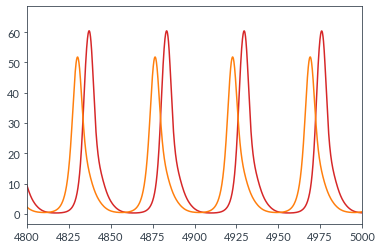

In [6]:
Cmat = np.ones((2,2))
np.fill_diagonal(Cmat, 0)
Dmat = Cmat.copy()
Dmat *= 50 

aln2 = ALNModel(Cmat = Cmat, Dmat = Dmat)
# Put ALN in "A3" Point right inside the LC_EI
aln2.params['mue_ext_mean'] = 1.1
aln2.params['mui_ext_mean'] = 0.5

# no adaptation 
aln2.params['a'] = 0.
aln2.params['b'] = 0. 

# coupling strength
aln2.params['Ke_gl'] = 20.
aln2.params['dt'] = 0.1
aln2.params['duration'] = 5 * 1000 

def delayToVelocity(delay, distance=50):
    '''delay in my, distance in mm'''
    return distance / delay

delay = 3.25
aln2.params['signalV'] = delayToVelocity(delay)

aln2.run()
plt.plot(aln2.t, aln2.rates_exc[0, :], color = "tab:red", label = "E 1")
plt.plot(aln2.t, aln2.rates_exc[1, :], color = "tab:orange", label = "E 2")
plt.xlim(4800, 5000)

INFO:root:aln: Model initialized.


(4800.0, 5000.0)

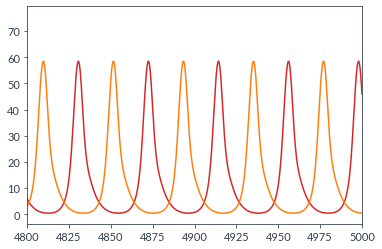

In [8]:
Cmat = np.ones((2,2))
np.fill_diagonal(Cmat, 0)
Dmat = Cmat.copy()
Dmat *= 50 

aln3 = ALNModel(Cmat = Cmat, Dmat = Dmat)
# Put ALN in "A3" Point right inside the LC_EI
aln3.params['mue_ext_mean'] = 1.1
aln3.params['mui_ext_mean'] = 0.5

# no adaptation 
aln3.params['a'] = 0.
aln3.params['b'] = 0. 

# coupling strength
aln3.params['Ke_gl'] = 20.
aln3.params['dt'] = 0.1
aln3.params['duration'] = 5 * 1000 

def delayToVelocity(delay, distance=50):
    '''delay in my, distance in mm'''
    return distance / delay

delay = 6
aln3.params['signalV'] = delayToVelocity(delay)

aln3.run()
plt.plot(aln3.t, aln3.rates_exc[0, :], color = "tab:red", label = "E 1")
plt.plot(aln3.t, aln3.rates_exc[1, :], color = "tab:orange", label = "E 2")
plt.xlim(4800, 5000)

(4800.0, 5000.0)

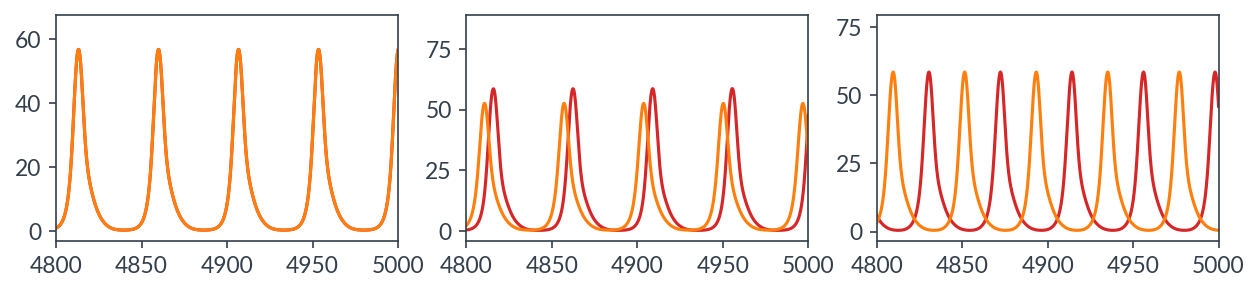

In [9]:
fig, axs = plt.subplots(1,3,  figsize=(10, 2), dpi=150)
axs[0].plot(aln1.t, aln1.rates_exc[0, :], color = "tab:red")
axs[0].plot(aln1.t, aln1.rates_exc[1, :], color = "tab:orange")

axs[0].set_xlim(4800, 5000)

axs[1].plot(aln2.t, aln2.rates_exc[0, :], color = "tab:red")
axs[1].plot(aln2.t, aln2.rates_exc[1, :], color = "tab:orange")

axs[1].set_xlim(4800, 5000)

axs[2].plot(aln3.t, aln3.rates_exc[0, :], color = "tab:red")
axs[2].plot(aln3.t, aln3.rates_exc[1, :], color = "tab:orange")

axs[2].set_xlim(4800, 5000)


# now with my style

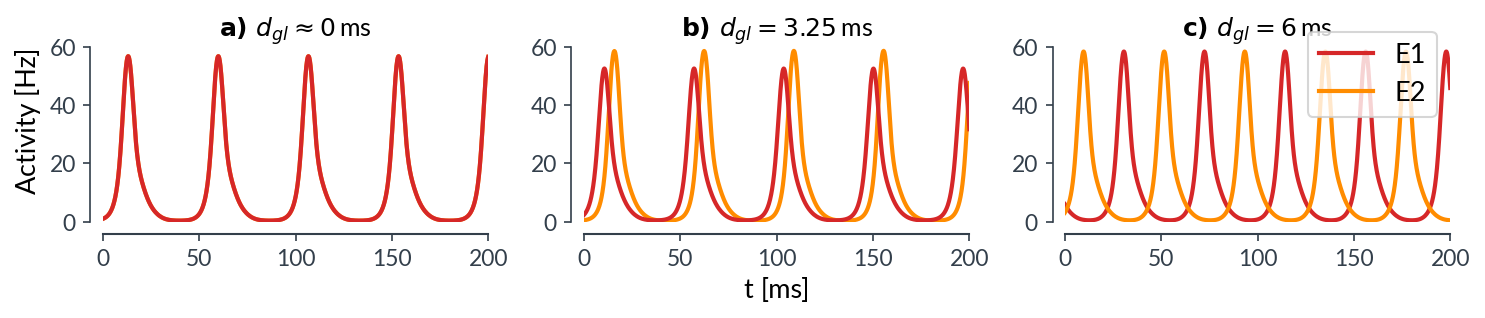

In [10]:
plt.rcParams['font.family'] = 'Lato'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

fig, axs = plt.subplots(1,3,  figsize=(10, 2.2), dpi=150)
axs[0].plot(aln1.t, aln1.rates_exc[0, :], color = "darkorange", lw=2)
axs[0].plot(aln1.t, aln1.rates_exc[1, :], color = "tab:red", lw=2)

axs[0].set_xlim(4800, 5000)
axs[0].tick_params(right=False, top=False)
axs[0].spines["top"].set_visible(False), axs[0].spines["right"].set_visible(False)
axs[0].set_ylim(0, 70)
plt.draw()
lab = [float(item.get_text().replace("−", "-")) for item in axs[0].get_yticklabels(which='both')][:-1]
axs[0].spines["left"].set_bounds(low=min(lab), high=max(lab))
axs[0].spines["left"].set_position(("outward", 6))
axs[0].set_xticks([4800, 4850, 4900, 4950, 5000])
axs[0].set_xticklabels(labels=['0', '50', '100', '150', '200'] )
axs[0].set_ylabel("Activity [Hz]")
axs[0].set_title(r'$\bf{a)}\ $$d_{gl} \approx 0\,$ms', y=0.85)

axs[1].plot(aln2.t, aln2.rates_exc[0, :], color = "darkorange", lw=2)
axs[1].plot(aln2.t, aln2.rates_exc[1, :], color = "tab:red", lw=2)

axs[1].set_xlim(4800, 5000)
axs[1].tick_params(right=False, top=False)
axs[1].spines["top"].set_visible(False), axs[1].spines["right"].set_visible(False)
axs[1].set_ylim(0, 70)
axs[1].spines["left"].set_bounds(low=0, high=60)
axs[1].spines["left"].set_position(("outward", 6))
axs[1].set_xticks([4800, 4850, 4900, 4950, 5000])
axs[1].set_xticklabels(labels=['0', '50', '100', '150', '200'] )
axs[1].set_xlabel("t [ms]")
axs[1].set_title(r'$\bf{b)}\ $$d_{gl} = 3.25\,$ms', y=0.85)


axs[2].plot(aln3.t, aln3.rates_exc[0, :], color = "tab:red", label="E1", lw=2)
axs[2].plot(aln3.t, aln3.rates_exc[1, :], color = "darkorange", label="E2", lw=2)

axs[2].set_xlim(4800, 5000)
axs[2].tick_params(right=False, top=False)
axs[2].spines["top"].set_visible(False), axs[2].spines["right"].set_visible(False)
axs[2].set_ylim(0, 70)
axs[2].spines["left"].set_bounds(low=0, high=60)
axs[2].spines["left"].set_position(("outward", 6))
axs[2].set_xticks([4800, 4850, 4900, 4950, 5000])
axs[2].set_xticklabels(labels=['0', '50', '100', '150', '200'] )
axs[2].legend(loc="upper right")
axs[2].set_title(r'$\bf{c)}\ $$d_{gl} = 6\, $ms', y=0.85)

for line in ["bottom"]:
    axs[0].spines[line].set_linewidth(1)
    axs[0].spines[line].set_position(("outward",6))
    axs[1].spines[line].set_linewidth(1)
    axs[1].spines[line].set_position(("outward",6))
    axs[2].spines[line].set_linewidth(1)
    axs[2].spines[line].set_position(("outward",6))
    
fig.tight_layout()
#fig.savefig("Pics/Two_Node_ts_2.pdf")

In [2]:
# from neurolib.utils.functions
def construct_stimulus(
    stim="dc",
    duration=6000,
    dt=0.1,
    stim_amp=0.2,
    stim_freq=1,
    stim_bias=0,
    n_periods=None,
    nostim_before=0,
    nostim_after=0,
):
    """Constructs a stimulus that can be applied to a model

    :param stim: Stimulation type: 'ac':oscillatory stimulus, 'dc': stimple step current, 
                'rect': step current in negative then positive direction with slowly
                decaying amplitude, used for bistability detection, defaults to 'dc'
    :type stim: str, optional
    :param duration: Duration of stimulus in ms, defaults to 6000
    :type duration: int, optional
    :param dt: Integration time step in ms, defaults to 0.1
    :type dt: float, optional
    :param stim_amp: Amplitude of stimulus (for AdEx: in mV/ms, multiply by conductance C to get current in pA), defaults to 0.2
    :type stim_amp: float, optional
    :param stim_freq: Stimulation frequency, defaults to 1
    :type stim_freq: int, optional
    :param stim_bias: Stimulation offset (bias), defaults to 0
    :type stim_bias: int, optional
    :param n_periods: Numer of periods of stimulus, defaults to None
    :type n_periods: [type], optional
    :param nostim_before: Time before stimulation, defaults to 0
    :type nostim_before: int, optional
    :param nostim_after: Time after stimulation, defaults to 0
    :type nostim_after: int, optional
    :raises ValueError: Raises error if unsupported stimulus type is chosen.
    :return: Stimulus timeseries
    :rtype: numpy.ndarray
    """
    """Constructs a sitmulus that can be applied as input to a model

    TODO: rewrite

    stim:       Stimulus type: 'ac':oscillatory stimulus, 'dc': stimple step current, 
                'rect': step current in negative then positive direction with slowly
                decaying amplitude, used for bistability detection
    stim_amp:   Amplitude of stimulus (for AdEx: in mV/ms, multiply by conductance C to get current in pA)
    """
    def sinus_stim(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        return np.tile(sinus_function, cycles)

    if stim == "ac":
        """Oscillatory stimulus
        """
        n_periods = n_periods or int(stim_freq)

        stimulus = np.hstack(
            ([stim_bias] * int(nostim_before / dt), np.tile(sinus_stim(stim_freq, stim_amp) + stim_bias, n_periods),)
        )
        stimulus = np.hstack((stimulus, [stim_bias] * int(nostim_after / dt)))
    elif stim == "dc":
        """Simple DC input and return to baseline
        """
        stimulus = np.hstack(([stim_bias] * int(nostim_before / dt), [stim_bias + stim_amp] * int(1000 / dt)))
        stimulus = np.hstack((stimulus, [stim_bias] * int(nostim_after / dt)))
        stimulus[stimulus < 0] = 0
    elif stim == "rect":
        """Rectified step current with slow decay
        """
        # construct input
        stimulus = np.zeros(int(duration / dt))
        tot_len = int(duration / dt)
        stim_epoch = tot_len / 6

        stim_increase_counter = 0
        stim_decrease_counter = 0
        stim_step_increase = 5.0 / stim_epoch

        for i, m in enumerate(stimulus):
            if 0 * stim_epoch <= i < 0.5 * stim_epoch:
                stimulus[i] -= stim_amp
            elif 0.5 * stim_epoch <= i < 3.0 * stim_epoch:
                stimulus[i] = -np.exp(-stim_increase_counter) * stim_amp
                stim_increase_counter += stim_step_increase
            elif 3.0 * stim_epoch <= i < 3.5 * stim_epoch:
                stimulus[i] += stim_amp
            elif 3.5 * stim_epoch <= i < 5 * stim_epoch:
                stimulus[i] = np.exp(-stim_decrease_counter) * stim_amp
                stim_decrease_counter += stim_step_increase
    else:
        raise ValueError(f'Stimulus {stim} not found. Use "ac", "dc" or "rect".')

    # repeat stimulus until full length
    steps = int(duration / dt)
    stimlength = int(len(stimulus))
    print(stimlength)
    stimulus = np.tile(stimulus, int(steps / stimlength + 2))
    stimulus = stimulus[:steps]

    return stimulus

def construct_inphase_stimulus(   
    duration=6000,
    dt=0.1,
    stim_amp=0.2,
    stim_freq_in=1,
    stim_bias=0,
    n_periods_in=None,
    nostim_before=0,
    nostim_after=0,
    decay=False
):
    def sinus_stim(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        return np.tile(sinus_function, cycles)
    
    def sinus_stim_decay(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        stim = np.tile(sinus_function, cycles)

        decay_len = len(stim) / 6 # should decay to 1 / 6e
        stim_decrease_counter = 0
        stim_step_increase = 1/decay_len
        for i, m in enumerate(stim):
            if i < len(stim)/2:
                pass
            else:
                stim[i] *= np.exp(-stim_decrease_counter) 
                stim_decrease_counter += stim_step_increase
        return stim
    
    # create two stimuli and then hstack
    #### IN-PHASE STIMULUS
    n_periods_in = n_periods_in or int(stim_freq_in)
        
    if decay:
        oscillation_in_phase = sinus_stim_decay(stim_freq_in, stim_amp, cycles = n_periods_in)
    else:
        oscillation_in_phase = sinus_stim(stim_freq_in, stim_amp, cycles = n_periods_in)

    stimulus_in_phase = np.hstack(
        ([stim_bias] * int(nostim_before / dt), oscillation_in_phase + stim_bias)
    ) 
    stimulus = np.hstack((stimulus_in_phase, [stim_bias] * int(nostim_after / dt))) #could make variable nostim_between if necessary
    
        
    steps = int(duration / dt)
    stimlength = int(len(stimulus))
    stimulus = np.tile(stimulus,int(steps / stimlength + 2))
    stimulus = stimulus[:steps]

    return stimulus
 
def construct_antiphase_stimulus(   
    duration=6000,
    dt=0.1,
    stim_amp=0.2,
    stim_freq_anti=2,
    stim_bias=0,
    n_periods_anti=None,
    nostim_before=0,
    nostim_after=0,
    decay=False
):
    def sinus_stim(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        return np.tile(sinus_function, cycles)
    
    def sinus_stim_decay(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        stim = np.tile(sinus_function, cycles)

        decay_len = len(stim) / 6 # should decay to 1 / 6e
        stim_decrease_counter = 0
        stim_step_increase = 1/decay_len
        for i, m in enumerate(stim):
            if i < len(stim)/2:
                pass
            else:
                stim[i] *= np.exp(-stim_decrease_counter) 
                stim_decrease_counter += stim_step_increase
        return stim
    
    ### ANTI-PHASE STIMULUS
    n_periods_anti = n_periods_anti or int(stim_freq_anti)
    
    if decay:
        oscillation_anti = sinus_stim_decay(stim_freq_anti, stim_amp, cycles = n_periods_anti)
    else:
        oscillation_anti = sinus_stim(stim_freq_anti, stim_amp, cycles = n_periods_anti)

    stimulus_anti_phase = np.hstack(
        ([stim_bias] * int(nostim_before / dt), oscillation_anti + stim_bias)
    )
    stimulus = np.hstack((stimulus_anti_phase, [stim_bias] * int(nostim_after / dt)))
    
    steps = int(duration / dt)
    stimlength = int(len(stimulus))
    stimulus = np.tile(stimulus, int(steps / stimlength + 2))
    stimulus = stimulus[:steps]
    stimulus_anti = -stimulus + 2*stim_bias
    
    stimuli = np.ndarray( (2, int(duration / dt)) )
    
    stimuli[0] = stimulus
    stimuli[1] = stimulus_anti
    return stimulus, stimulus_anti
 
def construct_inphase_antiphase_stimulus(   
    duration=6000,
    dt=0.1,
    stim_amp=0.2,
    stim_freq_in=1,
    stim_freq_anti=2,
    stim_bias=0,
    n_periods_in=None,
    n_periods_anti=None,
    nostim_before=0,
    nostim_after=0,
    nostim_between=0,
    decay=False
):
    def sinus_stim(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        return np.tile(sinus_function, cycles)
    
    def sinus_stim_decay(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        stim = np.tile(sinus_function, cycles)

        decay_len = len(stim) / 6 # should decay to 1 / 6e
        stim_decrease_counter = 0
        stim_step_increase = 1/decay_len
        for i, m in enumerate(stim):
            if i < len(stim)/2:
                pass
            else:
                stim[i] *= np.exp(-stim_decrease_counter) 
                stim_decrease_counter += stim_step_increase
        return stim
    
    # create two stimuli and then hstack
    #### IN-PHASE STIMULUS
    n_periods_in = n_periods_in or int(stim_freq_in)
        
    if decay:
        oscillation_in_phase = sinus_stim_decay(stim_freq_in, stim_amp, cycles = n_periods_in)
    else:
        oscillation_in_phase = sinus_stim(stim_freq_in, stim_amp, cycles = n_periods_in)

    stimulus_in_phase = np.hstack(
        ([stim_bias] * int(nostim_before / dt), oscillation_in_phase + stim_bias)
    ) 
    stimulus_in_phase = np.hstack((stimulus_in_phase, [stim_bias] * int(nostim_between / dt))) #could make variable nostim_between if necessary
    
    ### ANTI-PHASE STIMULUS
    n_periods_anti = n_periods_anti or int(stim_freq_anti)
    
    if decay:
        oscillation_anti = sinus_stim_decay(stim_freq_anti, stim_amp, cycles = n_periods_anti)
    else:
        oscillation_anti = sinus_stim(stim_freq_anti, stim_amp, cycles = n_periods_anti)

    stimulus_anti_phase = np.hstack(
        ([stim_bias] * int(nostim_before / dt), oscillation_anti + stim_bias)
    )
    stimulus_anti_phase = np.hstack((stimulus_anti_phase, [stim_bias] * int(nostim_after / dt)))
    

    stimulus = np.hstack((stimulus_in_phase, stimulus_anti_phase))
    stimulus_anti = np.hstack((stimulus_in_phase, -stimulus_anti_phase + 2*stim_bias))
    
    steps = int(duration / dt)
    stimlength = int(len(stimulus))
    stimulus = np.tile(stimulus, int(steps / stimlength + 2))
    stimulus = stimulus[:steps]
    stimulus_anti = np.tile(stimulus_anti, int(steps / stimlength + 2))
    stimulus_anti = stimulus_anti[:steps]
    
    stimuli = np.ndarray( (2, int(duration / dt)) )
    stimuli[0] = stimulus
    stimuli[1] = stimulus_anti
    return stimulus, stimulus_anti
 